# EDA of MMSE

In [2]:
# import required modules
import warnings
warnings.filterwarnings('ignore')

import pickle

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import pearsonr
from scipy.stats import ttest_1samp
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

import seaborn.apionly as sns
sns.set_context("poster")
from IPython.display import display
matplotlib.style.use('ggplot')
%matplotlib inline


In [3]:
# we define a function to calculate the Concordance Correlation Coefficient (a measure to evaluate our models)
def ccc_function(y,y_hat):
    pcc, _ = pearsonr(y_hat,y)
    ccc = 2 * pcc * y.std() * y_hat.std()/(y.var() + y_hat.var() + (y.mean() - y_hat.mean())**2)
    return ccc

In [4]:
# function to evaluate our quantitative models and store the result in a summary dictionary
def evaluate_and_store(y_train,y_hat_train,y_test,y_hat_test,name,summary):
    # input:
    # y_train,y_hat_train,y_test,y_hat_test
    # summary: dictionary with fields model name, R2train, R2test, PCC and CCC
    pcc, _ = pearsonr(y_test,y_hat_test)
    ccc = ccc_function(y_test,y_hat_test)
    r2train = r2_score(y_train,y_hat_train)
    r2test = r2_score(y_test,y_hat_test)
    summary['model name'].append(name)
    summary['R2train'].append(r2train)
    summary['R2test'].append(r2test)
    summary['PCC'].append(pcc)
    summary['CCC'].append(ccc)
    return r2train,r2test,pcc,ccc,summary

# set up a summary dictionary
summary = {'model name':[],'R2train':[],'R2test':[],"PCC":[],'CCC':[]}


## EDA of MMSE and demographic factors
  
We downloaded the data for this part of the analysis from the [ADNI download page]( https://ida.loni.usc.edu/pages/access/studyData.jsp?categoryId=43&subCategoryId=94) (password-protected login).  
The data in the baseline_data.csv file consists of 628 rows corresponding to unique observations of 628 patients. It contains 2150 measurements of brain geometry derived from 3D MRI images, e.g. area, thickness, curvature, etc. of different brain regions. It can be assumed that many of these variables are correlated with each other because of geometrical necessity.  
The spreadsheet also contains demographic data such as education, ethnicity, gender, race and age as well as some diagnostic data: MMSE score, Diagnosis, Apoe4 genotype. The Apoe4 allele is a polymorphism of the Apo E gene that is associated with AD susceptibility. In addition, there is an indicator variable for Apoe4 imputation.    
We cleaned up the demographic variables in the following way: gender, ethnicity and genotype imputation were converted to binary variables, race and ApoE4 allele number were converted to binary dummy variables. All ID variables were dropped from the analysis. The remaining variables are all quantitative.  
We checked all demographic and diagnostic variables for a correlation with the MMSE score (our outcome variable). As shown in figure 4a (Appendix), the diagnosis is strongly correlated with MMSE score. Patients with Late Mild Cognitive Impairment (LMCI) and especially Alzheimer’s patients (AD) have lower scores than control patients(CN). Since the diagnosis is not an easy to obtain predictor, we exclude the diagnosis from the predictors. Instead, we turn the diagnosis into another (categorical) outcome variable that we can try to predict from the rest of the data. If we manage to successfully predict the MMSE score we could try to predict the diagnosis from our predicted MMSE score


In [5]:
#read data from file
data = pd.read_csv('baseline_data.csv')

#split data into image data and demographic data
image_data = data.iloc[:,:-13].copy()
demographic = data.iloc[:,-13:].copy()
mmse = data['MMSE']
# for diagnosis: CN = 0, LMCI = 1, AD = 2
dx = (data['DX.bl'] == 'LMCI') * 1. + (data['DX.bl'] == 'AD') * 2.


We checked all demographic and diagnostic variables for a correlation with the MMSE score (our outcome variable). As shown in the figure below, the diagnosis is strongly correlated with MMSE score. Patients with Late Mild Cognitive Impairment (LMCI) and especially Alzheimer’s patients (AD) have lower scores than control patients(CN). Since the diagnosis is not an easy to obtain predictor, we exclude the diagnosis from the predictors. Instead, we turn the diagnosis into another (categorical) outcome variable that we can try to predict from the rest of the data.
The ApoE4 allele number also influences MMSE scores (Fig 4b). 
On the other hand, other demographic predictors like gender or age do not appear to be strongly correlated with the MMSE score.  

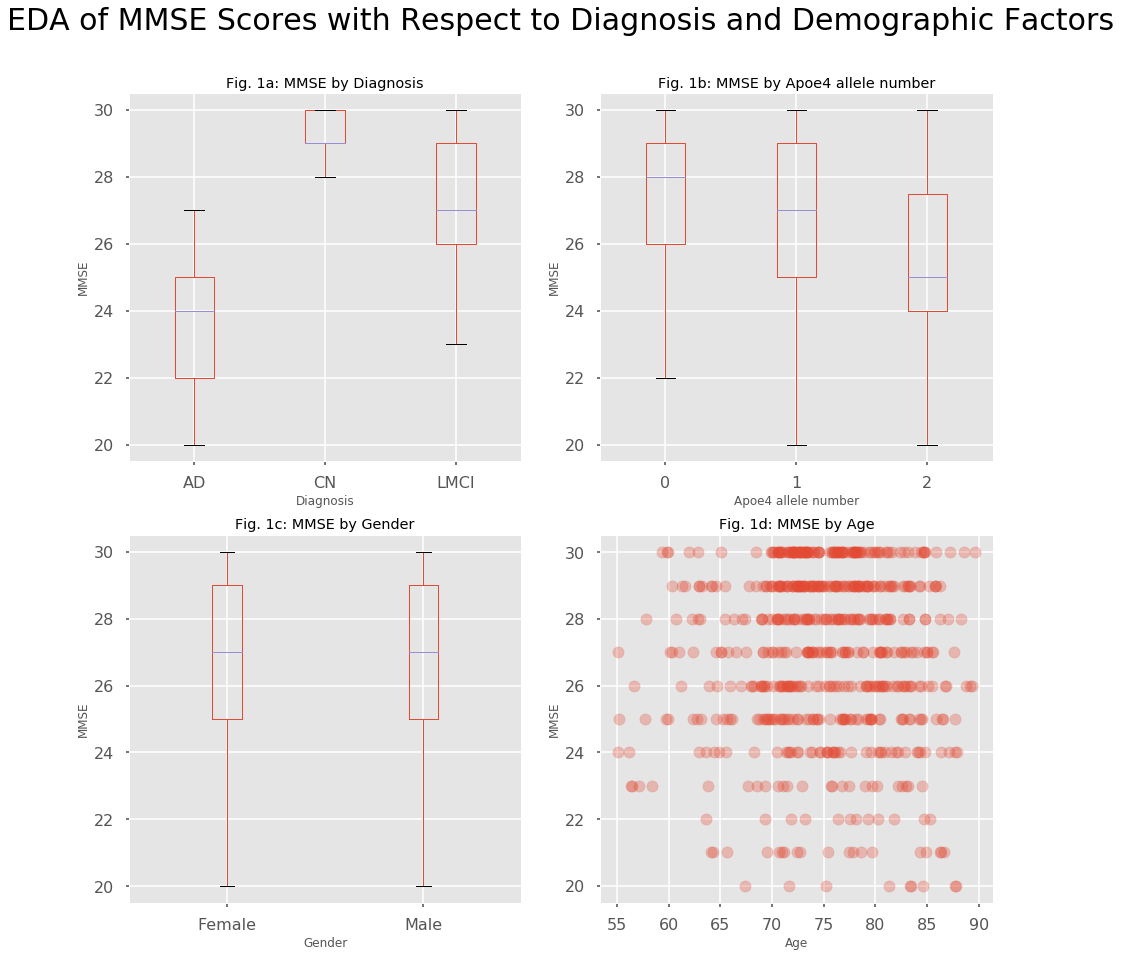

In [6]:
fig1 = plt.figure(figsize = [15,15])


plt.subplot(2,2,1)
ax = plt.gca()
data.boxplot('MMSE',by = ['DX.bl'], ax = ax)
plt.title('Fig. 1a: MMSE by Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('MMSE')

plt.subplot(2,2,2)
ax = plt.gca()
data.boxplot('MMSE',by = ['APOE4'], ax = ax)
plt.title('Fig. 1b: MMSE by Apoe4 allele number')
plt.xlabel('Apoe4 allele number')
plt.ylabel('MMSE')

plt.subplot(2,2,3)
ax = plt.gca()
data.boxplot('MMSE',by = ['PTGENDER'], ax = ax)
plt.title('Fig. 1c: MMSE by Gender')
plt.xlabel('Gender')
plt.ylabel('MMSE')

plt.subplot(2,2,4)
ax = plt.gca()
plt.scatter(data['AGE'],mmse,alpha=0.3)
plt.title('Fig. 1d: MMSE by Age')
plt.xlabel('Age')
plt.ylabel('MMSE');


fig1.suptitle('EDA of MMSE Scores with Respect to Diagnosis and Demographic Factors',fontsize= 30);

## EDA of MMSE and demographic factors
  
  
Furthermore, we managed to determine the predictors in the imaging dataset that have the highest Pearson’s correlation coefficient with the MMSE score and plotted them against the MMSE score.

In [8]:
# find the image data columns that are most correlated with mmse

corr_coefs = []
pvals = []

for column in image_data.columns.values:
    coef,pval = pearsonr(image_data[column],mmse)
    corr_coefs.append(coef)
    pvals.append(pval)
    
print("image measurements most closely correlated with MMSE score:")
best6 = image_data.columns.values[np.argsort(pvals)[:6]]
print(best6)


image measurements most closely correlated with mmse score:
['FreeSurfer.thickness..mean.1006' 'FreeSurfer.thickness..mean.2006'
 'FreeSurfer.thickness..25..1006' 'FreeSurfer.thickness..median.1006'
 'FreeSurfer.thickness..75..1006' 'FreeSurfer.thickness..25..1009']


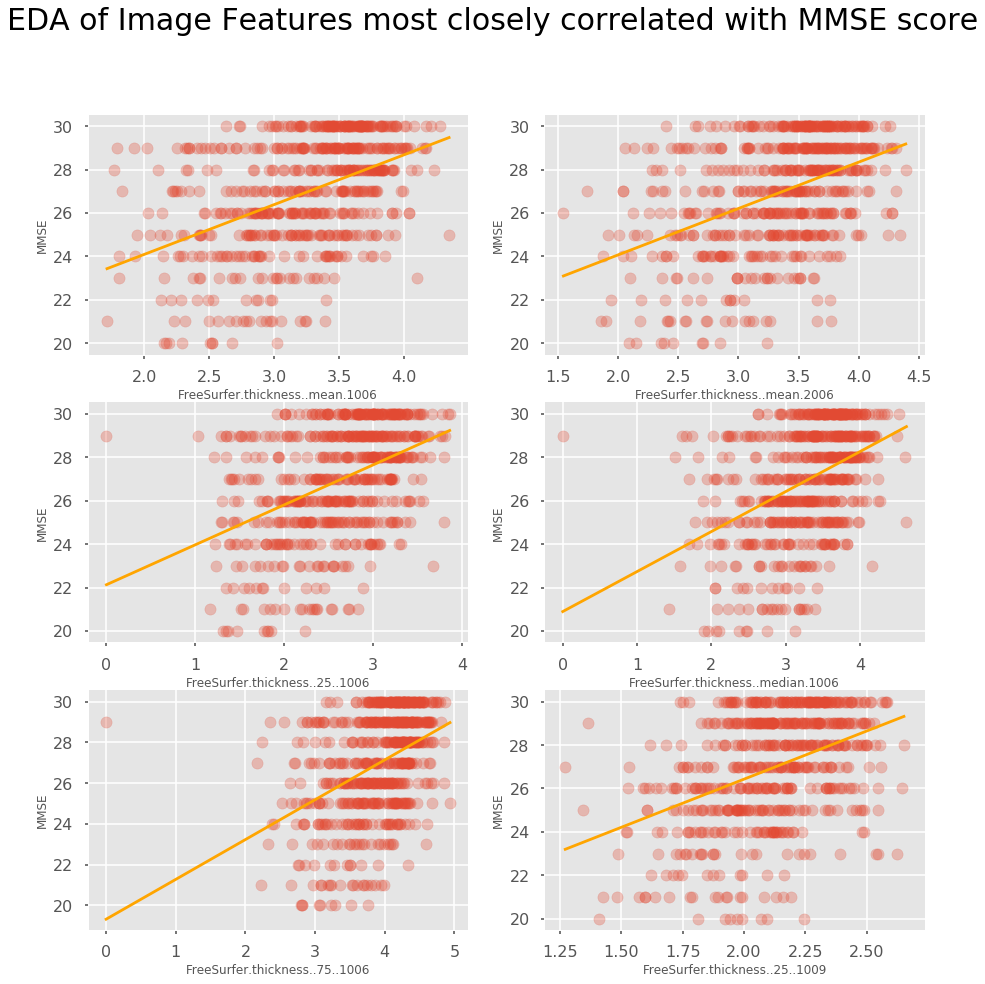

In [9]:
# plot mmse vs most closely correlated image measurements
fig2 = plt.figure(figsize= [15,15])

for i,feature in enumerate(best6):
    plt.subplot(3,2,i+1)
    plt.scatter(image_data[feature],mmse,alpha=0.3)
    plt.xlabel(feature)
    plt.ylabel('MMSE')
    beta1,beta0 = np.polyfit(image_data[feature],mmse,deg=1)
    f = lambda x: beta1 * x + beta0
    x = np.array([np.min(image_data[feature]), np.max(image_data[feature])])
    plt.plot(x,f(x),c='orange')
    sns.despine()
fig2.suptitle('EDA of Image Features most closely correlated with MMSE score',fontsize= 30);  

Some of the features in the imaging data appear to be strongly correlated with the MMSE score which makes the analysis/prediction promising. 
We also notice that we now have 2159 predictors which is a lot more than the 628 observations we have in our complete dataset. This causes a big danger of overfitting any training data.  


In [10]:
# clean up demographic variables

# impute Unknown as Not Hisp/Latino and turn into binary with Hisp/Latino as 1.0, Non-Hisp/Latino as 0.0
demographic['PTETHCAT'] = (demographic.PTETHCAT == 'Hisp/Latino') * 1.

# race and number of Apoe4 alleles are turned into dummy variables
demographic = pd.get_dummies(demographic,columns=['PTRACCAT','APOE4'],drop_first=True)

# turn gender into a binary variable with Female = 1.0
demographic['PTGENDER'] = (demographic.PTGENDER == 'Female') * 1.

# change imputed_genotype from boolean to 0.0/1.0
demographic['imputed_genotype'] = (demographic.imputed_genotype == True)* 1.

# get X and y ; we have 2 different outcome variables: y = MMSE score for the main body of this analysis and
# y_dx = diagnosis for evaluating our predicted MMSE in the last part
y = mmse
y_dx = dx

image_columns = image_data.columns.values

# we discard the ID columns and the diagnosis column which would give away too much
demographic_columns = ['AGE','PTGENDER','PTEDUCAT','PTETHCAT','imputed_genotype','PTRACCAT_Black','PTRACCAT_White','APOE4_1','APOE4_2']


# and concatenate the image and remaining demographic data
X = pd.concat([image_data,demographic[demographic_columns]],axis=1)

# train test split: we have 2 different outcome variables: y = MMSE score for the main body of this analysis and
# y_dx = diagnosis for evaluating our predicted MMSE in the last part
X_train, X_test, y_train, y_test, y_dx_train, y_dx_test = train_test_split(X,y,y_dx,train_size = 0.75,random_state=8)


# standardize training and test
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [9]:

with open('mmse_data1.pickle', 'wb') as f:
    pickle.dump((X_train,X_test,y_train,y_test,y_dx_train,y_dx_test,summary), f, protocol=pickle.HIGHEST_PROTOCOL)
   

## Checking Multi-Colinearity in the Imaging Data
  
  
As mentioned above, we suspect that there is multi-collinearity between imaging predictors. To investigate this, we calculate a correlation matrix between the predictors and display it as a heatmap.

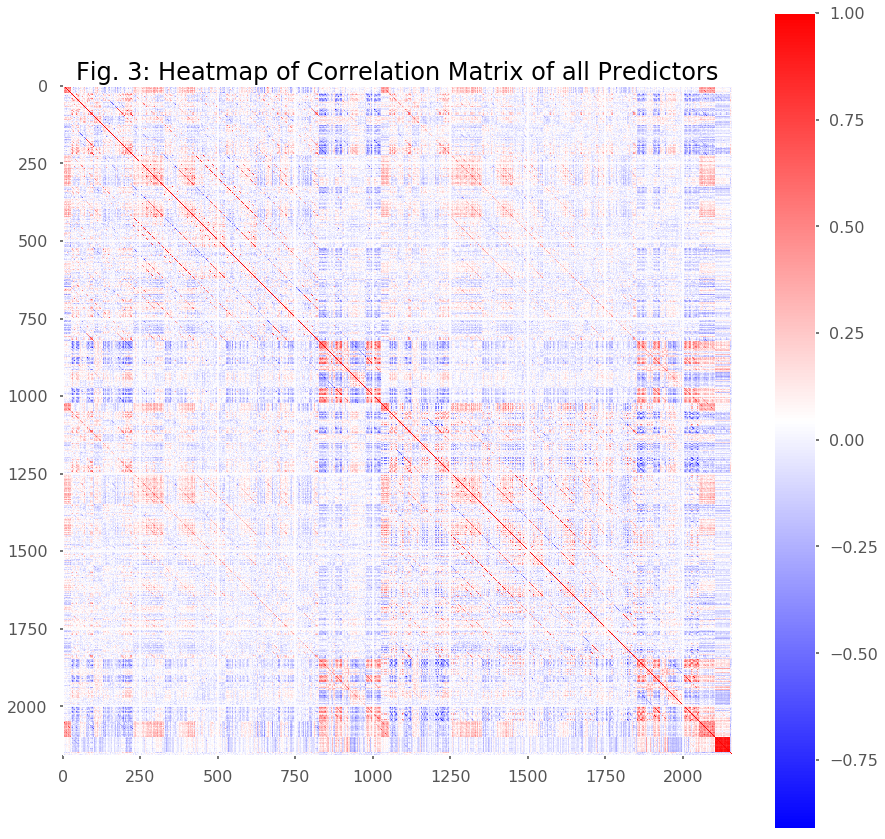

In [10]:
# get and plot correlation matrix
corr_mat = np.corrcoef(X_train.as_matrix().T)

# plot correlation matrix
fig3 = plt.figure(figsize = [15,15])
ax = plt.gca()
plt.set_cmap("bwr")
heatmap = plt.imshow(corr_mat)
plt.title('Heatmap of Correlation Matrix of all Predictors',fontsize=24);
plt.colorbar(heatmap);

There is a lot of colinearity between the predictors in the imaging data. Colinear variables appear to be organized in ordered blocks. In order to get a working prediction model, we will have to reduce the dimensionality and co-linearity  to reduce the danger of overfitting to the training set. Overcoming the problems of overfitting and high variance appear to be the major challenge of this project.